## Import and Load

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# seeds 
seed = 12341
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
df = pd.read_csv("data/ml-25m/ratings.csv").dropna()
df['time'] = pd.to_datetime(df['timestamp'], unit='s')
df['rating'] = df['rating'] / df['rating'].max()

train = (
    df
    .query("time.dt.year == 2019 & time.dt.month <= 5")
)

test = (
    df
    .query("time.dt.year == 2019 & time.dt.month == 6")
)

del df

train = (
    train
    .loc[train.userId.isin(test.userId.unique()) & train.movieId.isin(test.movieId.unique())]
)

user_months = (
    train
    .assign(month = lambda d: d.time.dt.year.astype(str) + d.time.dt.month.astype(str))
    .groupby('userId')
    .month
    .nunique()
)

users_to_keep = user_months[user_months == 5].index

train = (
    train
    .loc[train.userId.isin(users_to_keep)]
)

test = (
    test
    .loc[test.userId.isin(train.userId.unique()) & test.movieId.isin(train.movieId.unique())]
)

len(train), len(test)

(46645, 5024)

In [8]:
user_ids = list(train.userId.unique())
train['user_id_for_model'] = train['userId'].apply(user_ids.index)
test['user_id_for_model'] = test['userId'].apply(user_ids.index)

movie_ids = list(train.movieId.unique())
train['movie_id_for_model'] = train['movieId'].apply(movie_ids.index)
test['movie_id_for_model'] = test['movieId'].apply(movie_ids.index)

## PMF

In [9]:
from numpy.random import RandomState

class PMF(nn.Module):
	def __init__(self, n_users, n_items, n_factors=20, is_sparse=False, no_cuda=None):
		super(PMF, self).__init__()
		self.n_users = n_users
		self.n_items = n_items
		self.n_factors = n_factors
		self.random_state = RandomState(1)

		# M,D
		self.user_embeddings = nn.Embedding(n_users, n_factors, sparse=is_sparse)
		self.user_embeddings.weight.data = torch.from_numpy(self.random_state.rand(n_users, n_factors)).float()
		
		# NxD
		self.item_embeddings = nn.Embedding(n_items, n_factors, sparse=is_sparse)
		self.item_embeddings.weight.data = torch.from_numpy(self.random_state.rand(n_items, n_factors)).float()


		self.relu = nn.ReLU()
	
	def forward(self, users_index=None, items_index=None):
		if users_index is not None and items_index is not None:
			user_h1 = self.user_embeddings(users_index)
			item_h1 = self.item_embeddings(items_index)
			R_h = torch.dot(user_h1, item_h1)
		else:
			R_h = self.item_embeddings.weight.data @ self.user_embeddings.weight.data.T
		return nn.functional.sigmoid(R_h)

	def __call__(self, *args):
		return self.forward(*args)


	def predict(self, users_index=None, items_index=None):
		# preds = self.forward(users_index, items_index)
		if users_index and items_index:
			preds = self.forward(users_index, items_index)
		else:
			user_h1 = self.user_embeddings(users_index)
			item_h1 = self.item_embeddings(items_index)
			preds = (user_h1 * item_h1).sum(1)
		return preds


def RMSE(preds, truth):
    return np.sqrt(np.mean(np.square(preds-truth)))

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10


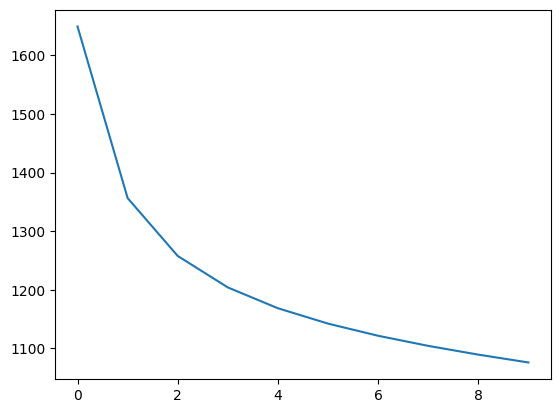

In [10]:
model = PMF(n_users=train['user_id_for_model'].max() + 1, n_items=train['movie_id_for_model'].max() + 1, n_factors=2)

epochs = 10
lr = 0.1
reg = 0.01

loss_SGD = []

for i in range(epochs):
    print("epoch", i + 1)
    interim = 0
    
    for _, row in train.iterrows():
      user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
      # making a pridiction in forward pass
      y_hat = model.forward(users_index=user, items_index=item)
      error = row['rating'] - y_hat

      interim += np.square(error.detach().numpy())
      
      # updates
      # Pi ← Pi + α(eij Qj − λPi ) 
      model.user_embeddings.weight.data[user, :] = \
        model.user_embeddings.weight.data[user, :] + \
        lr * (error * model.item_embeddings.weight.data[item, :] - reg * model.user_embeddings.weight.data[user, :])
      # Qj ← Qj + α(eij Pi − λQj )
      model.item_embeddings.weight.data[item, :] = \
        model.item_embeddings.weight.data[item, :] + \
        lr * (error * model.user_embeddings.weight.data[user, :] - reg * model.item_embeddings.weight.data[item, :])
    loss_SGD.append(interim)

plt.plot(loss_SGD)

In [12]:
import pickle
pickle.dump(model, open('pmf' + '.pkl', "wb"))

In [13]:
preds = []
for _, row in train.iterrows():
    user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
    preds.append(model.forward(users_index=user, items_index=item).detach().numpy())

len(preds)

46645

In [14]:
import numpy as np
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmse(train['rating'], np.array(preds))

0.15268061161032842

In [17]:
preds = []
for _, row in test.iterrows():
    user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
    preds.append(model.forward(users_index=user, items_index=item).detach().numpy())
rmse(test['rating'], np.array(preds))

0.170176743608102

## TempMF

In [15]:
from numpy.random import RandomState

class TempMF(nn.Module):
	def __init__(self, n_users, t_steps, item_embeddings, n_factors=20, is_sparse=False, no_cuda=None):
		super(TempMF, self).__init__()
		self.n_users = n_users

		self.n_factors = n_factors
		self.random_state = RandomState(1)

		self.user_embeddings = torch.zeros([n_users, n_factors, t_steps])

		# N,D
		self.item_embeddings = item_embeddings

		self.relu = nn.ReLU()
	
	def forward(self, time_index, users_index=None, items_index=None):
		if users_index!=None and items_index!=None:
			user_h1 = self.user_embeddings[users_index,:,time_index]
			item_h1 = self.item_embeddings(items_index)
			R_h = torch.dot(user_h1, item_h1)
		else:
			R_h = self.item_embeddings.weight.data @ self.user_embeddings[:,:,time_index].T
		return nn.functional.sigmoid(R_h)

	def __call__(self, *args):
		return self.forward(*args)

	def predict(self, time_index, users_index=None, items_index=None):
		preds = self.forward(time_index, users_index, items_index)
		return preds

In [18]:
time_steps = 5
train_updated = (
    train
    .assign(bin = lambda d: d.time.dt.month - 1)
)

train_updated['bin'].value_counts()

bin
0    19509
1     8448
2     6725
4     6272
3     5691
Name: count, dtype: int64

In [19]:
tempMF = TempMF(n_users=model.n_users, t_steps=time_steps, item_embeddings=model.item_embeddings, n_factors=model.n_factors)

epochs = 10
lr = 0.1
reg = 0.01

loss_SGD = []

# time
for t in range(time_steps):
    print("time:", t + 1)
    tempMF.user_embeddings[:,:,t] = model.user_embeddings.weight.data

    # iterations
    for iter in range(epochs):
      print(f"Epoch {iter}")
      interim = 0

      # ratings
      for _, row in train_updated[train_updated['bin'] == t].iterrows():
        user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
        y_hat = tempMF.forward(time_index=t, users_index=user, items_index=item)
        error = row['rating'] - y_hat
        interim += np.square(error.detach().numpy())
        
        tempMF.user_embeddings[user, :, t] = \
          tempMF.user_embeddings[user, :, t] + \
          lr * (error * tempMF.item_embeddings.weight.data[item, :] - reg * tempMF.user_embeddings[user, :, t])
      loss_SGD.append(interim)

plt.plot(loss_SGD)

time: 1
Epoch 0
Epoch 1


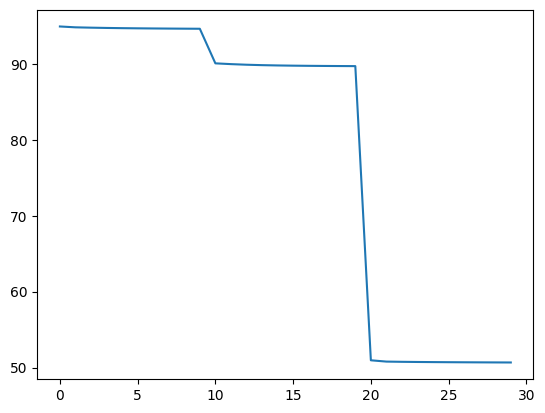

In [221]:
plt.plot(loss_SGD)

In [222]:
preds = []
for _, row in train_updated.iterrows():
    user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
    preds.append(tempMF.forward(time_index = torch.tensor(row['bin']).to(torch.int), users_index=user, items_index=item).detach().numpy())

rmse(train_updated['rating'], np.array(preds))

0.1530349670712741

In [223]:
preds = []
for _, row in train_updated.iterrows():
    user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
    preds.append(tempMF.forward(time_index = torch.tensor(0).to(torch.int), users_index=user, items_index=item).detach().numpy())
rmse(train_updated['rating'], np.array(preds))

0.15427275293533046

#### Lasso Regression: Drift

In [300]:
y = tempMF.user_embeddings[:,:,1:].detach()
X = tempMF.user_embeddings[:,:,:-1].detach()
X.shape, y.shape

(torch.Size([75, 2, 2]), torch.Size([75, 2, 2]))

In [309]:
#Initializing weights and biases
A = torch.randn(tempMF.n_users, tempMF.n_factors, tempMF.n_factors, requires_grad=True)
b = torch.randn(tempMF.n_users, tempMF.n_factors, requires_grad=True)

# Define the model
def transition_model(X, A, b):
    return torch.einsum('idt,zdd->idt', X, A) + b[:, None]

# regularization parameter
reg = 0.01
lr = 1e-4

#MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff*diff)/(2 * diff.shape[-1]) + reg * torch.norm(A, 1)

losses = []


# Train for 100 epochs
for i in range(100000):
    preds = transition_model(X, A, b)
    loss = mse(preds, y)
    losses.append(loss.detach().numpy())
    if i == 0:
        loss.backward(retain_graph=True)
    else:
        loss.backward()
    with torch.no_grad():
        A -= A.grad * lr
        b -= b.grad * lr
        A.grad.zero_()
        b.grad.zero_()

# Calculate loss
preds = transition_model(X, A, b)
loss = mse(preds, y)
print(loss)

tensor(2.2620, grad_fn=<AddBackward0>)


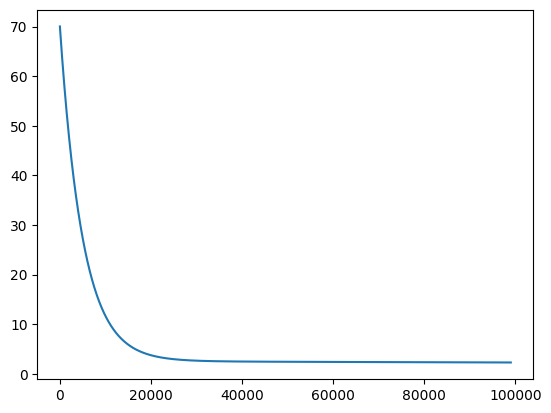

In [311]:
plt.plot(losses[1000:])

In [312]:
embeddings_2 = transition_model(X[:, :, 0].unsqueeze(2), A, b)
embeddings_3 = transition_model(embeddings_2[:, :, 0].unsqueeze(2), A, b)
all_embeddings = [X[:, :, 0], embeddings_2[:, :, 0], embeddings_3[:, :, 0]]
preds = []

for _, row in train_updated.iterrows():
    user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int) 
    user_emb = all_embeddings[int(row['bin'])][int(user), :].squeeze()
    item_emb = tempMF.item_embeddings(item)
    preds.append(nn.functional.sigmoid(torch.dot(user_emb, item_emb)).detach().numpy())

rmse(train_updated['rating'], np.array(preds))

0.15342193366386822

In [298]:
preds = []

for _, row in train_updated.iterrows():
    user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int) 
    user_emb = X[int(user), :, 0].squeeze()
    item_emb = tempMF.item_embeddings(item)
    preds.append(nn.functional.sigmoid(torch.dot(user_emb, item_emb)).detach().numpy())

rmse(train_updated['rating'], np.array(preds))

0.15427275293533046